# Notebook

In [1]:
# installs- comment out if good

!git clone https://github.com/wtlu71/cnn-comp-med.git

import numpy as np
import os
from tqdm import tqdm
import sys
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

repo_path = '/content/cnn-comp-med'
# Add to Python path
sys.path.append(repo_path)
# imports
from my_scripts.test import potato
from my_scripts.my_models import SmallCNN, SmallMLP,LargeCNN
from my_scripts.dataset_loading import H5Dataset
from my_scripts.utils import run_epoch


import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, Subset,TensorDataset
import torchvision.models as models
from torchvision.models import resnet50
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
weights_folder = "weights"
dataset_folder = os.path.join(os.getcwd(),"data")
external_dataset_folder = "breast-histopathology-images-subset"

Cloning into 'cnn-comp-med'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 134 (delta 70), reused 30 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 5.04 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
!pip install -U gdown

In [3]:
os.makedirs(weights_folder,exist_ok=True)
os.makedirs(external_dataset_folder,exist_ok=True)
download = True # set true if need to download
if download:
  !gdown --folder --remaining-ok https://drive.google.com/drive/folders/1EnF-qAa2JMD66KRQCIs-xOUmWiXiDA11 -O weights #weights folder storing train,test,val stratified idx
  !gdown --folder --remaining-ok https://drive.google.com/drive/folders/14EiLf9I6FGopdydykxPLmVXsiltzBGDH -O data #saved data for deterministic results
  !gdown --id 1lAtil7jdHGi9MM6d3WbxALmYYWVC_2R5 -O breast-histopathology-images-subset.zip #external testing subset
  !unzip -q breast-histopathology-images-subset.zip

Retrieving folder contents
Retrieving folder 1TGWX-NN_KmssOnxQucKMhV_t_Fbxobsm .ipynb_checkpoints
Retrieving folder 18Lyiz4SQdaDn0Ot0oQj4lN9NKf5qkd_e resnet
Processing file 1Z72UXI0XmKiYEEQJDAyV3LFp15_mG4pM resnet.pth
Processing file 1HncVXpZ74ubG0dDDgOJ2mwZL8ANnMiCH efficientNet.pth
Processing file 19nhMhct1JG_61LIP5YLLEURSLT0i1Xkh LargeCNN_subset.pth
Processing file 1SXSm5-C9mwdvmPzfgOlcqj0UipK17PWg ResNet_subset.pth
Processing file 1XDoT88p-K5nU-gwBq-26c0OCOM9Nrzyp ResNet.pth
Processing file 14o0LoXRmt-YvXEE1fIqXUlvKmxoFtSxw SmallCNN_subset.pth
Processing file 1_CjNFjxdXJztdQAb6ASvm_mPQluqU_Jk SmallMLP_subset.pth
Processing file 1HkfPOp6pRIM6aYzYTyV7jDjRgueM5PjH test.idx.npy
Processing file 1j9CoCJtBHgbnvM4ZrT2mz4wqYQ341Hoz test.npy
Processing file 1QXXpAsAGwGknjcOl-j8-TjALetQObNdn train.idx.npy
Processing file 1Yl_L14-Q-tGEOEa0KOZwxOnGGulPxHtC train.npy
Processing file 1HLwctzyNbIAUcoIpwvh7RXNbA0f27S8V val.idx.npy
Processing file 1krzZg7q3pTGPbILC9U9nt4YCFblIRme_ val.npy
Retrieving

Get train/val/test data from Zenodo:

In [4]:
os.makedirs(dataset_folder,exist_ok=True)
# !apt-get install -y wget2
if download:
  !apt-get install -y aria2

  # !aria2c -x 16 -s 16 -k 1M -c -j 1 "URL" -o output_filename
  #train
  !aria2c -x 16 -s 16 -k 1M -c -j 1 "https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_train_x.h5.gz?download=1" -o data/train_x.h5.gz
  !gunzip data/train_x.h5.gz

  !wget https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_train_y.h5.gz?download=1 -O data/train_y.h5.gz
  !gunzip data/train_y.h5.gz

  # val
  !aria2c -x 16 -s 16 -k 1M -c -j 1 "https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_valid_x.h5.gz?download=1" -o data/valid_x.h5.gz
  !gunzip data/valid_x.h5.gz

  !wget https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_valid_y.h5.gz?download=1 -O data/valid_y.h5.gz
  !gunzip data/valid_y.h5.gz

  # test
  !aria2c -x 16 -s 16 -k 1M -c -j 1 "https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_test_x.h5.gz?download=1" -o data/test_x.h5.gz
  !gunzip data/test_x.h5.gz

  !wget https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_test_y.h5.gz?download=1 -O data/test_y.h5.gz
  !gunzip data/test_y.h5.gz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 2s (680 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu

In [5]:
# define transforms

# is there a way to get this programmatically from the data or not worth it
IMG_SIZE = 96
BATCH_SIZE = 2048
# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

print("Data transforms defined")

Data transforms defined


In [6]:
def load_dataset(path):
  dataset_dict = torch.load(path)
  dataset = TensorDataset(dataset_dict['images'],dataset_dict['labels'])
  return dataset


def save_dataset(dataset,save_path):
  all_images = []
  all_labels = []

  for img, label in dataset:
      all_images.append(img)
      all_labels.append(label)

  save_dict = {
      "images": torch.stack(all_images),
      "labels": torch.tensor(all_labels),
  }

  torch.save(save_dict, save_path)

In [7]:

# dataset paths- Colab virtual session
load_saved = True
pin_memory = torch.cuda.is_available()

if load_saved:
  train_path = os.path.join(dataset_folder,"train_dataset.pt")
  test_path = os.path.join(dataset_folder,"test_dataset.pt")
  val_path = os.path.join(dataset_folder,"val_dataset.pt")
  external_dataset_path = os.path.join(dataset_folder,"external_test_dataset.pt")
  train_dataset = load_dataset(train_path)
  val_dataset = load_dataset(test_path)
  test_dataset = load_dataset(val_path)
  external_test_dataset = load_dataset(external_dataset_path)

else:
  train_img_h5_path = os.path.join(dataset_folder,"train_x.h5")
  train_label_h5_path = os.path.join(dataset_folder,"train_y.h5")

  val_img_h5_path = os.path.join(dataset_folder,"valid_x.h5")
  val_label_h5_path = os.path.join(dataset_folder,"valid_y.h5")

  test_img_h5_path = os.path.join(dataset_folder,"test_x.h5")
  test_label_h5_path = os.path.join(dataset_folder,"test_y.h5")


  train_subset_size = 50000 #keeping compute restraints in mind
  eval_subset_size = 5000
  use_precomputed_indices = True

  train_dataset = H5Dataset(train_img_h5_path,train_label_h5_path,transform=train_transforms)
  train_labels = np.array([label for _, label in train_dataset])

  val_dataset = H5Dataset(val_img_h5_path,val_label_h5_path,transform=train_transforms)
  val_labels = np.array([label for _, label in val_dataset])

  test_dataset = H5Dataset(test_img_h5_path,test_label_h5_path,transform=train_transforms)
  test_labels = np.array([label for _, label in test_dataset])

  if use_precomputed_indices:
    train_idx = np.load(os.path.join(weights_folder,f"train.npy"))
    val_idx = np.load(os.path.join(weights_folder,f"val.npy"))
    test_idx = np.load(os.path.join(weights_folder,f"test.npy"))
    test_idx = np.load(os.path.join(weights_folder,f"test.npy"))
  else:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_subset_size, random_state=RANDOM_STATE)
    train_idx, _ = next(sss.split(np.zeros(len(train_labels)), train_labels))  # indices for stratified subset
    np.save(os.path.join(weights_folder,f"train.npy"),train_idx)

    sss = StratifiedShuffleSplit(n_splits=1, train_size=eval_subset_size, random_state=RANDOM_STATE)
    val_idx, _ = next(sss.split(np.zeros(len(val_labels)), val_labels))  # indices for stratified subset
    np.save(os.path.join(weights_folder,f"val.npy"),val_idx)

    sss = StratifiedShuffleSplit(n_splits=1, train_size=eval_subset_size, random_state=RANDOM_STATE)
    test_idx, _ = next(sss.split(np.zeros(len(test_labels)), test_labels))  # indices for stratified subset
    np.save(os.path.join(weights_folder,f"test.npy"),test_idx)

  train_dataset = Subset(train_dataset, train_idx)
  val_dataset = Subset(val_dataset, val_idx)
  test_dataset = Subset(test_dataset, test_idx)
  #external is already stratified
  external_test_dataset = datasets.ImageFolder(external_dataset_folder,transform=eval_transforms)
  #ensure reproducibility of same stratified dataset used across runs
  save_dataset(train_dataset,"train_dataset.pt")
  save_dataset(val_dataset,"val_dataset.pt")
  save_dataset(test_dataset,"test_dataset.pt")
  save_dataset(external_test_dataset,"external_test_dataset.pt")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)
external_test_loader = DataLoader(external_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)

In [8]:
# define/load models
num_classes = 2
mlpmodel = SmallMLP(size=((IMG_SIZE,IMG_SIZE))).to(device)
smallcnnmodel = SmallCNN(channels=(32,64,128)).to(device)
largecnnmodel = LargeCNN(channels=(32,64,128,64,64,64)).to(device)

resnetmodel = resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2).to(device)
# resnetmodel = resnet50(weights = None).to(device)
resnetmodel.fc = nn.Linear(resnetmodel.fc.in_features, num_classes)
# wresnetmodel = models.wide_resnet50_2(pretrained=True).to(device)
# wresnetmodel.fc = nn.Linear(wresnetmodel.fc.in_features, num_classes)

modellist = [mlpmodel, smallcnnmodel, resnetmodel]
modeldict = {
    "SmallMLP": mlpmodel,
    "SmallCNN": smallcnnmodel,
    "LargeCNN": largecnnmodel,
    "ResNet": resnetmodel
}

# training hyperparameters
# can change learning rate or use scheduler
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 3e-4
# finetune with less epochs to avoid forgetting
# EPOCHS = 15
EPOCHS = 15
PATIENCE = EPOCHS
# patience- number of epochs the model continues after no improvement in validation loss

# consider other loss functions https://neptune.ai/blog/pytorch-loss-functions
criterion = nn.CrossEntropyLoss()
# don't change adam, never change dude

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


In [9]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()


Training SmallMLP...
SmallMLP has 442418 parameters

Starting training...



  7%|▋         | 1/15 [00:04<01:08,  4.91s/it]

Epoch 01: train_loss=1.0699 val_loss=1.3150 val_acc=0.524 val_auc=0.505


 13%|█▎        | 2/15 [00:08<00:53,  4.15s/it]

Epoch 02: train_loss=0.9028 val_loss=0.8136 val_acc=0.511 val_auc=0.499


 20%|██        | 3/15 [00:12<00:46,  3.91s/it]

Epoch 03: train_loss=0.8928 val_loss=1.1965 val_acc=0.520 val_auc=0.524


 27%|██▋       | 4/15 [00:15<00:41,  3.80s/it]

Epoch 04: train_loss=0.8970 val_loss=1.2668 val_acc=0.521 val_auc=0.524


 33%|███▎      | 5/15 [00:19<00:37,  3.74s/it]

Epoch 05: train_loss=0.8327 val_loss=1.0146 val_acc=0.521 val_auc=0.521


 40%|████      | 6/15 [00:23<00:33,  3.72s/it]

Epoch 06: train_loss=0.8231 val_loss=0.8347 val_acc=0.511 val_auc=0.499


 47%|████▋     | 7/15 [00:26<00:29,  3.70s/it]

Epoch 07: train_loss=0.8385 val_loss=1.0060 val_acc=0.521 val_auc=0.515


 53%|█████▎    | 8/15 [00:30<00:25,  3.68s/it]

Epoch 08: train_loss=0.8668 val_loss=1.2427 val_acc=0.520 val_auc=0.520


 60%|██████    | 9/15 [00:34<00:22,  3.67s/it]

Epoch 09: train_loss=0.8931 val_loss=1.1068 val_acc=0.522 val_auc=0.522


 67%|██████▋   | 10/15 [00:37<00:18,  3.67s/it]

Epoch 10: train_loss=0.8136 val_loss=0.8797 val_acc=0.519 val_auc=0.520


 73%|███████▎  | 11/15 [00:41<00:14,  3.65s/it]

Epoch 11: train_loss=0.7964 val_loss=0.9570 val_acc=0.502 val_auc=0.486


 80%|████████  | 12/15 [00:44<00:10,  3.64s/it]

Epoch 12: train_loss=1.0413 val_loss=0.9891 val_acc=0.484 val_auc=0.486


 87%|████████▋ | 13/15 [00:48<00:07,  3.64s/it]

Epoch 13: train_loss=0.8319 val_loss=0.8220 val_acc=0.500 val_auc=0.518


 93%|█████████▎| 14/15 [00:52<00:03,  3.64s/it]

Epoch 14: train_loss=0.7889 val_loss=1.1613 val_acc=0.500 val_auc=0.518


100%|██████████| 15/15 [00:55<00:00,  3.72s/it]

Epoch 15: train_loss=0.8955 val_loss=1.3482 val_acc=0.500 val_auc=0.517

Restored best model (val_auc=0.5242)


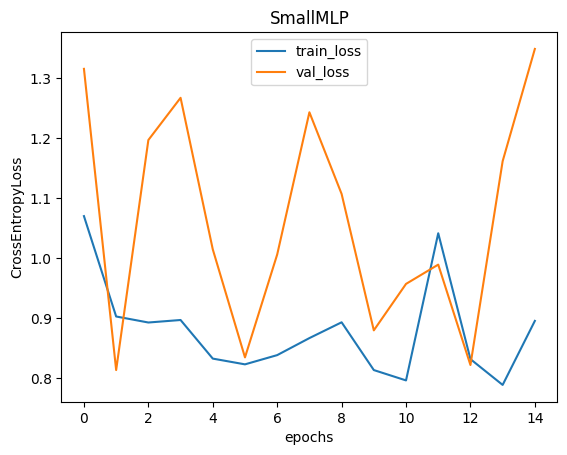

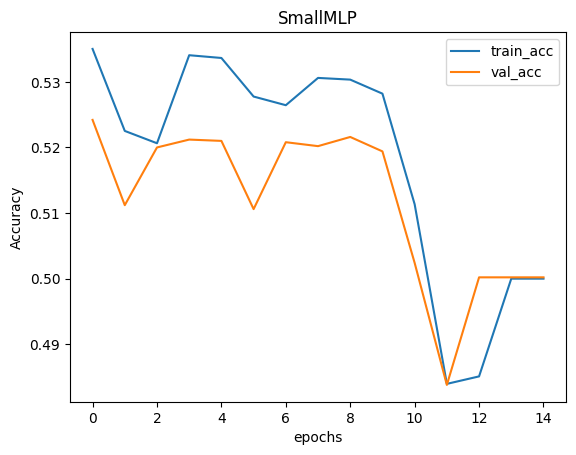

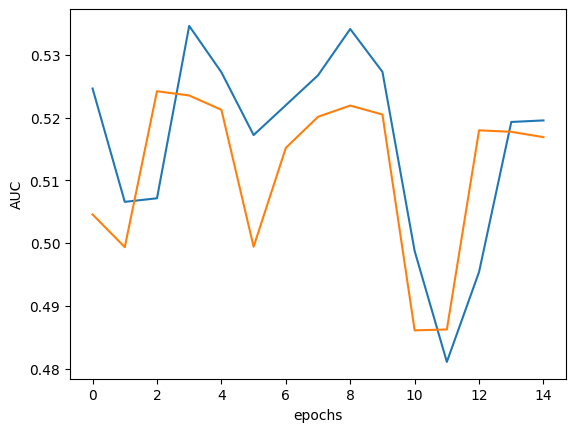

Training SmallCNN...
SmallCNN has 93954 parameters

Starting training...



  7%|▋         | 1/15 [00:06<01:35,  6.84s/it]

Epoch 01: train_loss=0.5466 val_loss=1.7823 val_acc=0.509 val_auc=0.669


 13%|█▎        | 2/15 [00:12<01:22,  6.37s/it]

Epoch 02: train_loss=0.5634 val_loss=0.8096 val_acc=0.614 val_auc=0.816


 20%|██        | 3/15 [00:18<01:14,  6.18s/it]

Epoch 03: train_loss=0.5648 val_loss=0.6187 val_acc=0.664 val_auc=0.725


 27%|██▋       | 4/15 [00:24<01:07,  6.13s/it]

Epoch 04: train_loss=0.5249 val_loss=0.9752 val_acc=0.546 val_auc=0.755


 33%|███▎      | 5/15 [00:30<01:01,  6.10s/it]

Epoch 05: train_loss=0.5936 val_loss=1.1763 val_acc=0.562 val_auc=0.795


 40%|████      | 6/15 [00:36<00:54,  6.05s/it]

Epoch 06: train_loss=0.5741 val_loss=0.8650 val_acc=0.650 val_auc=0.827


 47%|████▋     | 7/15 [00:42<00:48,  6.05s/it]

Epoch 07: train_loss=0.5069 val_loss=0.6246 val_acc=0.718 val_auc=0.809


 53%|█████▎    | 8/15 [00:49<00:42,  6.05s/it]

Epoch 08: train_loss=0.5992 val_loss=0.6488 val_acc=0.711 val_auc=0.779


 60%|██████    | 9/15 [00:54<00:36,  6.02s/it]

Epoch 09: train_loss=0.6785 val_loss=0.5743 val_acc=0.754 val_auc=0.818


 67%|██████▋   | 10/15 [01:01<00:30,  6.03s/it]

Epoch 10: train_loss=0.5400 val_loss=0.5308 val_acc=0.758 val_auc=0.853


 73%|███████▎  | 11/15 [01:07<00:24,  6.03s/it]

Epoch 11: train_loss=0.5471 val_loss=0.7191 val_acc=0.701 val_auc=0.853


 80%|████████  | 12/15 [01:13<00:18,  6.01s/it]

Epoch 12: train_loss=0.6563 val_loss=1.0148 val_acc=0.614 val_auc=0.821


 87%|████████▋ | 13/15 [01:18<00:11,  5.99s/it]

Epoch 13: train_loss=0.7062 val_loss=1.1269 val_acc=0.585 val_auc=0.759


 93%|█████████▎| 14/15 [01:24<00:05,  5.99s/it]

Epoch 14: train_loss=0.6133 val_loss=0.8880 val_acc=0.626 val_auc=0.784


100%|██████████| 15/15 [01:30<00:00,  6.06s/it]

Epoch 15: train_loss=0.4941 val_loss=0.5849 val_acc=0.713 val_auc=0.804

Restored best model (val_auc=0.8531)


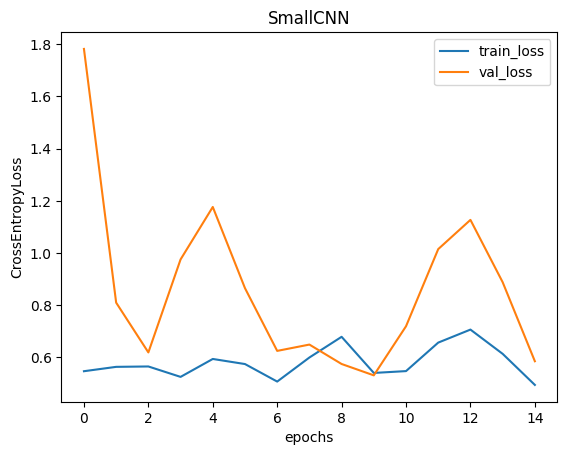

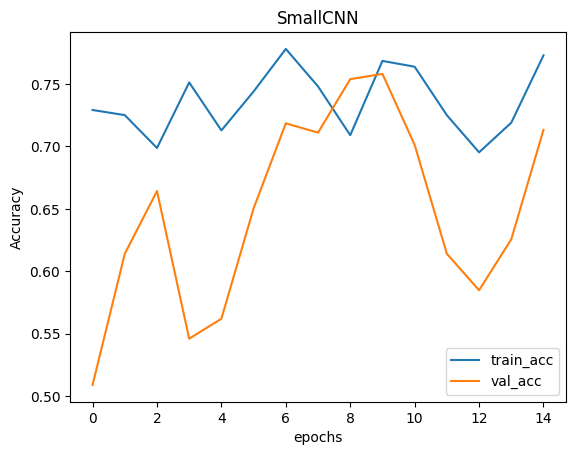

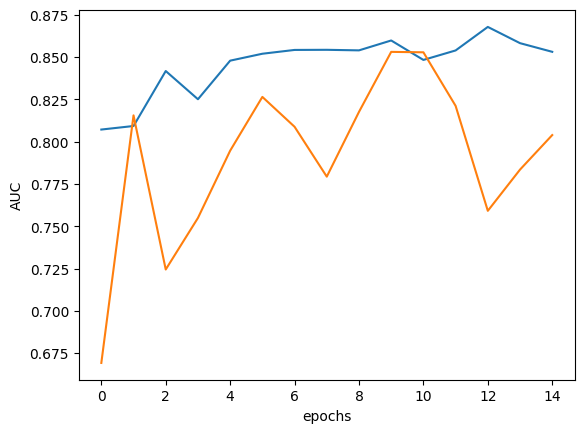

Training LargeCNN...
LargeCNN has 241858 parameters

Starting training...



  7%|▋         | 1/15 [00:06<01:25,  6.13s/it]

Epoch 01: train_loss=0.5829 val_loss=0.8591 val_acc=0.575 val_auc=0.807


 13%|█▎        | 2/15 [00:12<01:19,  6.12s/it]

Epoch 02: train_loss=0.5940 val_loss=2.6551 val_acc=0.530 val_auc=0.582


 20%|██        | 3/15 [00:18<01:13,  6.10s/it]

Epoch 03: train_loss=0.5181 val_loss=0.6662 val_acc=0.684 val_auc=0.836


 27%|██▋       | 4/15 [00:24<01:07,  6.10s/it]

Epoch 04: train_loss=0.5340 val_loss=0.7371 val_acc=0.638 val_auc=0.717


 33%|███▎      | 5/15 [00:30<01:01,  6.14s/it]

Epoch 05: train_loss=0.5111 val_loss=0.5910 val_acc=0.714 val_auc=0.835


 40%|████      | 6/15 [00:36<00:55,  6.13s/it]

Epoch 06: train_loss=0.5155 val_loss=0.6723 val_acc=0.714 val_auc=0.801


 47%|████▋     | 7/15 [00:42<00:48,  6.12s/it]

Epoch 07: train_loss=0.5056 val_loss=0.9193 val_acc=0.655 val_auc=0.702


 53%|█████▎    | 8/15 [00:48<00:42,  6.12s/it]

Epoch 08: train_loss=0.5168 val_loss=1.0015 val_acc=0.633 val_auc=0.672


 60%|██████    | 9/15 [00:55<00:36,  6.14s/it]

Epoch 09: train_loss=0.5082 val_loss=0.8013 val_acc=0.639 val_auc=0.749


 67%|██████▋   | 10/15 [01:01<00:30,  6.16s/it]

Epoch 10: train_loss=0.4796 val_loss=0.5683 val_acc=0.703 val_auc=0.828


 73%|███████▎  | 11/15 [01:07<00:24,  6.14s/it]

Epoch 11: train_loss=0.4858 val_loss=0.4970 val_acc=0.770 val_auc=0.848


 80%|████████  | 12/15 [01:13<00:18,  6.15s/it]

Epoch 12: train_loss=0.4851 val_loss=0.4854 val_acc=0.771 val_auc=0.853


 87%|████████▋ | 13/15 [01:19<00:12,  6.16s/it]

Epoch 13: train_loss=0.4755 val_loss=0.5336 val_acc=0.762 val_auc=0.841


 93%|█████████▎| 14/15 [01:26<00:06,  6.18s/it]

Epoch 14: train_loss=0.4745 val_loss=0.6219 val_acc=0.736 val_auc=0.828


100%|██████████| 15/15 [01:32<00:00,  6.14s/it]

Epoch 15: train_loss=0.4572 val_loss=0.7200 val_acc=0.702 val_auc=0.840

Restored best model (val_auc=0.8532)


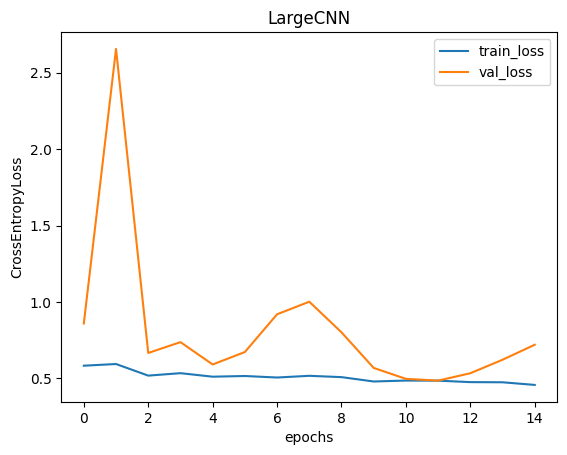

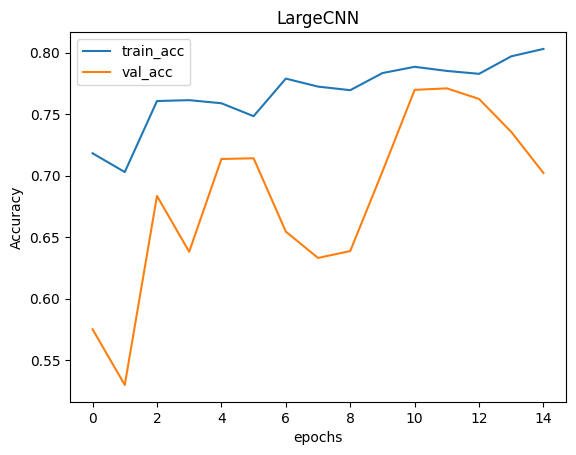

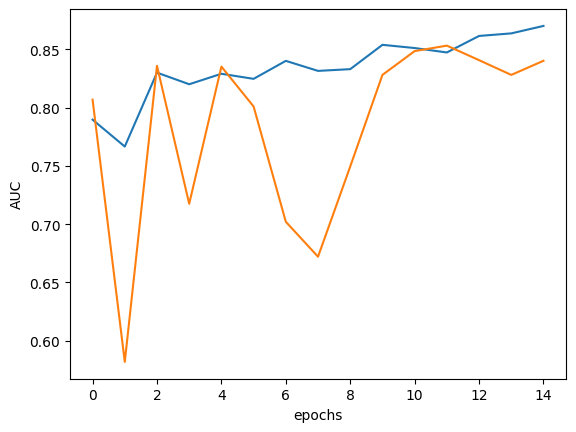

Training ResNet...
ResNet has 23512130 parameters

Starting training...



  7%|▋         | 1/15 [00:12<02:51, 12.24s/it]

Epoch 01: train_loss=0.4326 val_loss=0.7084 val_acc=0.798 val_auc=0.884


 13%|█▎        | 2/15 [00:24<02:38, 12.19s/it]

Epoch 02: train_loss=0.4134 val_loss=0.9476 val_acc=0.791 val_auc=0.861


 20%|██        | 3/15 [00:36<02:26, 12.18s/it]

Epoch 03: train_loss=0.4380 val_loss=0.6193 val_acc=0.726 val_auc=0.790


 27%|██▋       | 4/15 [00:48<02:13, 12.17s/it]

Epoch 04: train_loss=0.3893 val_loss=2.0994 val_acc=0.669 val_auc=0.764


 33%|███▎      | 5/15 [01:00<02:01, 12.10s/it]

Epoch 05: train_loss=0.3970 val_loss=8.0903 val_acc=0.749 val_auc=0.810


 40%|████      | 6/15 [01:12<01:49, 12.12s/it]

Epoch 06: train_loss=0.4221 val_loss=1.2112 val_acc=0.749 val_auc=0.851


 47%|████▋     | 7/15 [01:25<01:37, 12.13s/it]

Epoch 07: train_loss=0.4253 val_loss=0.7321 val_acc=0.760 val_auc=0.838


 53%|█████▎    | 8/15 [01:37<01:25, 12.14s/it]

Epoch 08: train_loss=0.3801 val_loss=0.5893 val_acc=0.744 val_auc=0.806


 60%|██████    | 9/15 [01:49<01:12, 12.12s/it]

Epoch 09: train_loss=0.3928 val_loss=0.5985 val_acc=0.801 val_auc=0.875


 67%|██████▋   | 10/15 [02:01<01:00, 12.11s/it]

Epoch 10: train_loss=0.3813 val_loss=0.9182 val_acc=0.736 val_auc=0.864


 73%|███████▎  | 11/15 [02:13<00:48, 12.12s/it]

Epoch 11: train_loss=0.3722 val_loss=0.5540 val_acc=0.805 val_auc=0.886


 80%|████████  | 12/15 [02:25<00:36, 12.10s/it]

Epoch 12: train_loss=0.4002 val_loss=0.5683 val_acc=0.793 val_auc=0.871


 87%|████████▋ | 13/15 [02:37<00:24, 12.10s/it]

Epoch 13: train_loss=0.3947 val_loss=0.5033 val_acc=0.763 val_auc=0.881


 93%|█████████▎| 14/15 [02:49<00:12, 12.06s/it]

Epoch 14: train_loss=0.4435 val_loss=5.8708 val_acc=0.779 val_auc=0.860


100%|██████████| 15/15 [03:01<00:00, 12.12s/it]

Epoch 15: train_loss=0.4057 val_loss=30.8364 val_acc=0.775 val_auc=0.855



Restored best model (val_auc=0.8865)


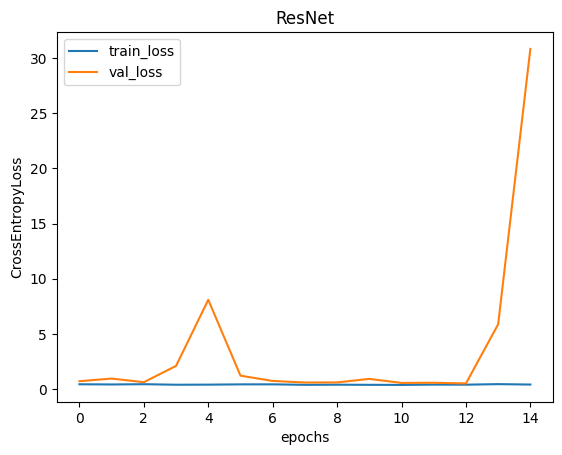

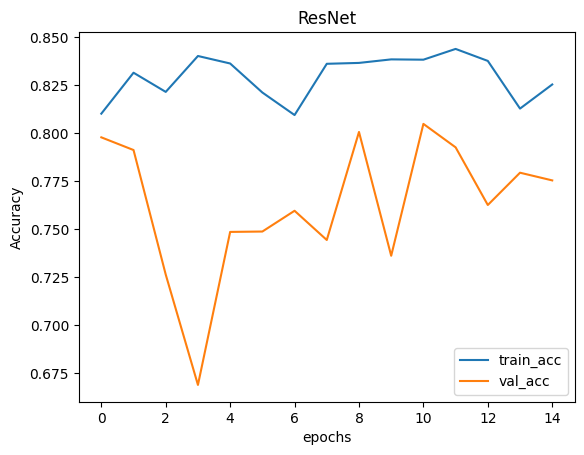

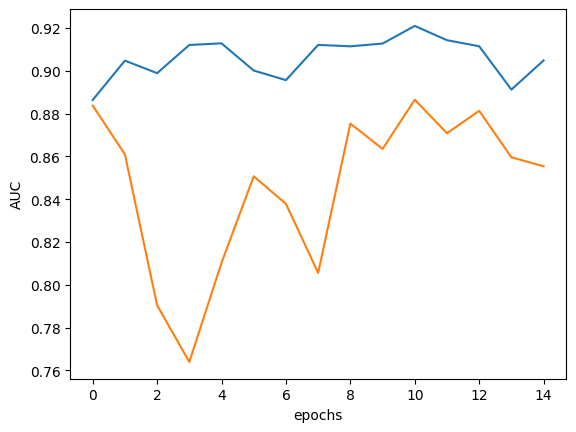

In [10]:

import matplotlib.pyplot as plt
historylist = []
stopepochs = []

for modelname, model in modeldict.items():
    print(f"Training {modelname}...")
    model.to(device)
    # print number of weights for each model
    num_params = sum(p.numel() for p in model.parameters())
    print(f"{modelname} has {num_params} parameters")
    optimizer = torch.optim.AdamW(model.parameters(),weight_decay=WEIGHT_DECAY, lr=LEARNING_RATE)

    # try to integrate into wandb instead of storing this so we can have a pretty dashboard?
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "train_auc": [],
        "val_acc": [],
        "val_auc": []
    }

    best_auc = -np.inf
    best_state = None
    bad_epochs = 0

    print("\nStarting training...\n")
    for epoch in tqdm(range(1, EPOCHS + 1)):
        tr_loss, tr_acc, _, _, tr_auc,_ = run_epoch(train_loader, model, criterion, optimizer=optimizer, train=True, device=device)
        va_loss, va_acc, va_sens, va_spec, va_auc,_ = run_epoch(val_loader, model, criterion, optimizer=None, train=False,device=device)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_auc"].append(tr_auc)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["val_auc"].append(va_auc)

        print(f"Epoch {epoch:02d}: "
            f"train_loss={tr_loss:.4f} "
            f"val_loss={va_loss:.4f} "
            f"val_acc={va_acc:.3f} "
            f"val_auc={va_auc:.3f}")

        if va_auc > best_auc + 1e-4:
            best_auc = va_auc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch}")
                break

    # Restore best model
    if best_state is not None:
        weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
        torch.save(best_state,weights_path)
        model.load_state_dict(best_state)
        print(f"\nRestored best model (val_auc={best_auc:.4f})")


    plt.plot(history["train_loss"],label="train_loss")
    plt.plot(history["val_loss"],label="val_loss")
    plt.xlabel("epochs")
    plt.ylabel("CrossEntropyLoss")
    plt.legend()
    plt.title(modelname)
    plt.show()
    plt.plot(history["train_acc"],label="train_acc")
    plt.plot(history["val_acc"],label="val_acc")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(modelname)
    plt.show()
    plt.plot(history["train_auc"],label="train_auc")
    plt.plot(history["val_auc"],label="val_auc")
    plt.xlabel("epochs")
    plt.ylabel("AUC")
    plt.show()

    historylist.append(history)
    stopepochs.append(epoch)

In [11]:
import json
history_path = os.path.join(weights_folder,"history.json")
with open(history_path,'w') as f:
  json.dump(historylist,f)

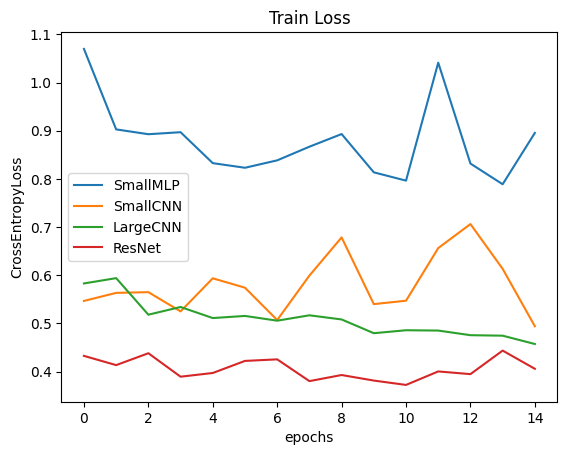

In [12]:

for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["train_loss"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("CrossEntropyLoss")
  plt.legend()
  plt.title("Train Loss")
  # plt.show()

plt.show()



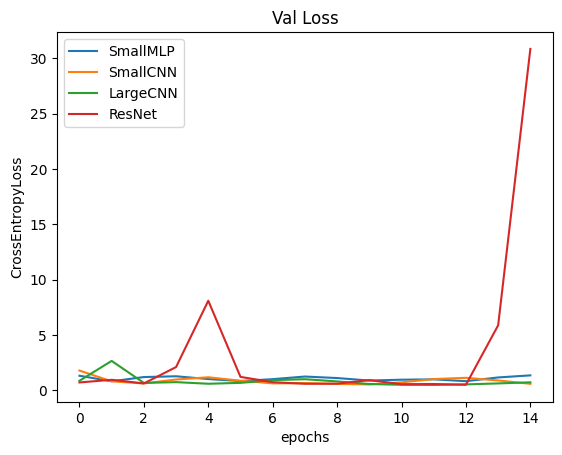

In [13]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["val_loss"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("CrossEntropyLoss")
  plt.legend()
  plt.title("Val Loss")
  # plt.show()

plt.show()



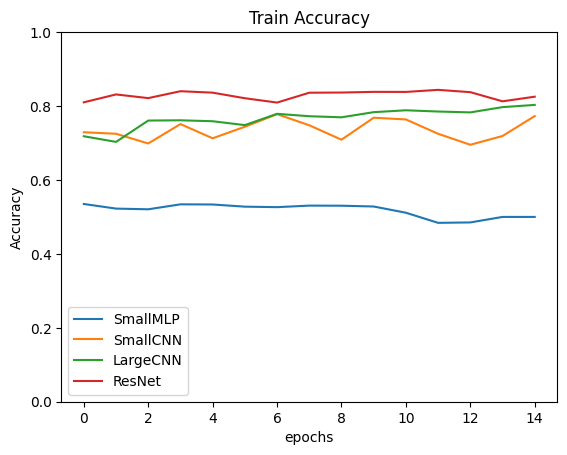

In [14]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["train_acc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Train Accuracy")
  plt.ylim([0,1])
  # plt.show()

plt.show()


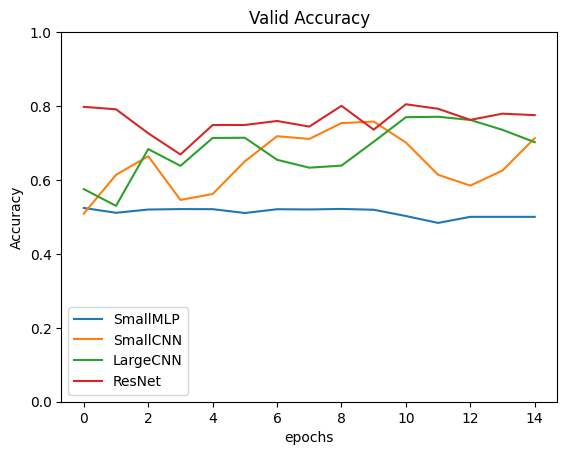

In [15]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["val_acc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Valid Accuracy")
  plt.ylim([0,1])
  # plt.show()

plt.show()

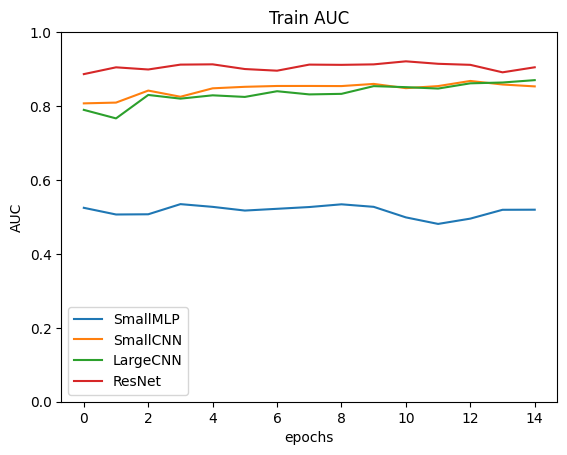

In [16]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["train_auc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("AUC")
  plt.legend()
  plt.title("Train AUC")
  plt.ylim([0,1])
  # plt.show()

plt.show()

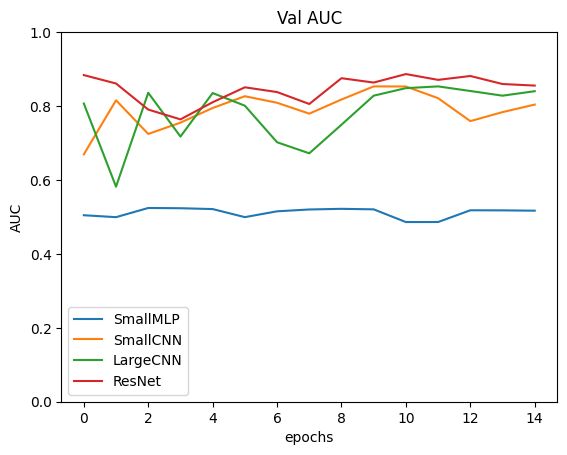

In [17]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["val_auc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("AUC")
  plt.legend()
  plt.title("Val AUC")
  plt.ylim([0,1])
  # plt.show()

plt.show()


Evaluating SmallMLP...
Final Validation Performance:
  AUC:         0.5468
  Accuracy:    0.5400
  Sensitivity: 0.9880
  Specificity: 0.0927


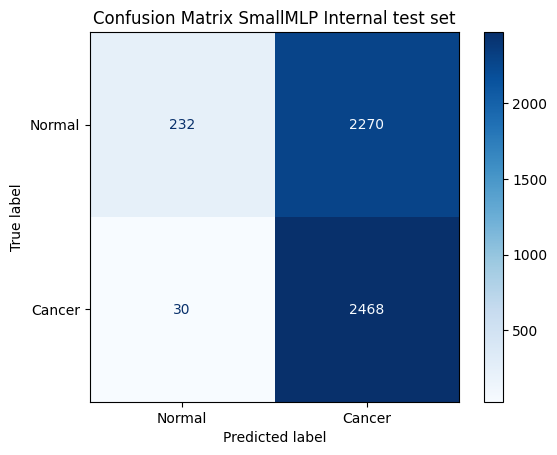


Evaluating SmallCNN...
Final Validation Performance:
  AUC:         0.8491
  Accuracy:    0.7446
  Sensitivity: 0.6361
  Specificity: 0.8529


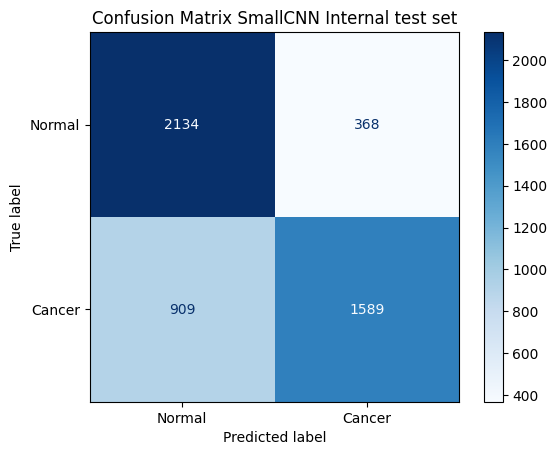


Evaluating LargeCNN...
Final Validation Performance:
  AUC:         0.8248
  Accuracy:    0.7630
  Sensitivity: 0.6581
  Specificity: 0.8677


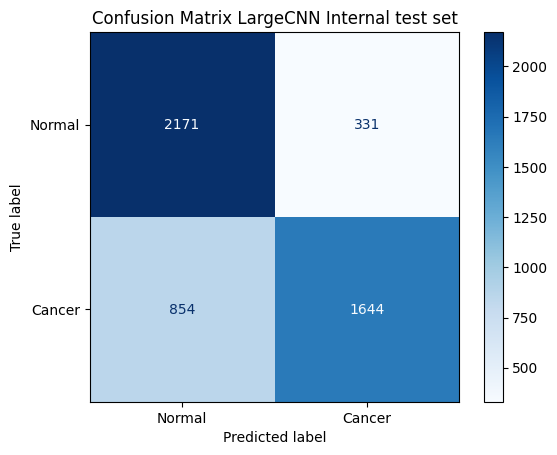


Evaluating ResNet...
Final Validation Performance:
  AUC:         0.8662
  Accuracy:    0.7872
  Sensitivity: 0.6857
  Specificity: 0.8885


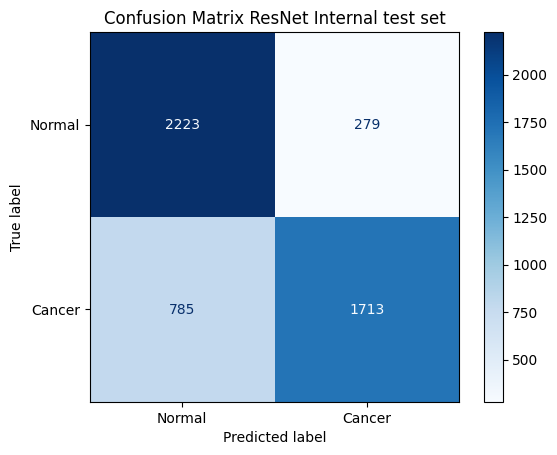

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# finally, evaluate on test set
# also do saliency

# model_attr_scores = []
# model_attr_channels = []
# model_preds = []
# model_targets = []

for modelname, model in modeldict.items():
  weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
  model_state_dict = torch.load(weights_path)
  model.load_state_dict(model_state_dict)
  print(f"\nEvaluating {modelname}...")
  model.to(device)
  _, va_acc, va_sens, va_spec, va_auc,cm = run_epoch(test_loader, model, criterion, train=False, device=device)
  print(f"Final Validation Performance:")
  print(f"  AUC:         {va_auc:.4f}")
  print(f"  Accuracy:    {va_acc:.4f}")
  print(f"  Sensitivity: {va_sens:.4f}")
  print(f"  Specificity: {va_spec:.4f}")
  class_names = ["Normal", "Cancer"]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=class_names)
  disp.plot(cmap='Blues', values_format='d')
  plt.title(f"Confusion Matrix {modelname} Internal test set")
  plt.show()




Evaluating SmallMLP...
Final Validation Performance:
  AUC:         0.4928
  Accuracy:    0.4963
  Sensitivity: 0.9912
  Specificity: 0.0016


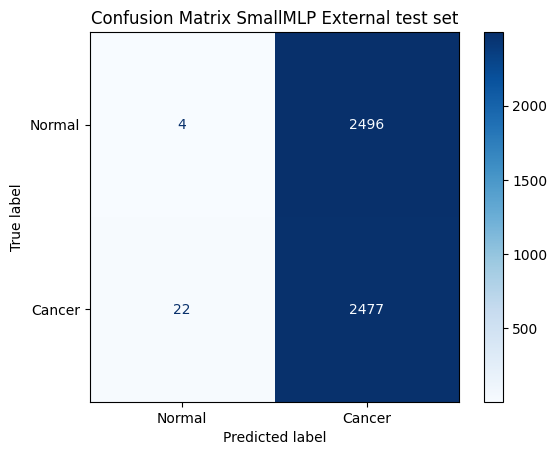


Evaluating SmallCNN...
Final Validation Performance:
  AUC:         0.9449
  Accuracy:    0.8236
  Sensitivity: 0.9664
  Specificity: 0.6808


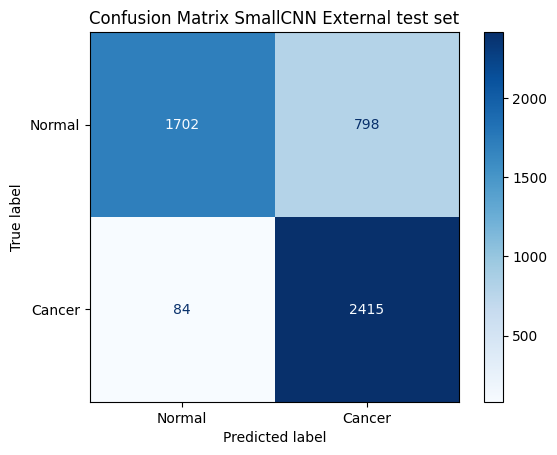


Evaluating LargeCNN...
Final Validation Performance:
  AUC:         0.9603
  Accuracy:    0.8554
  Sensitivity: 0.9640
  Specificity: 0.7468


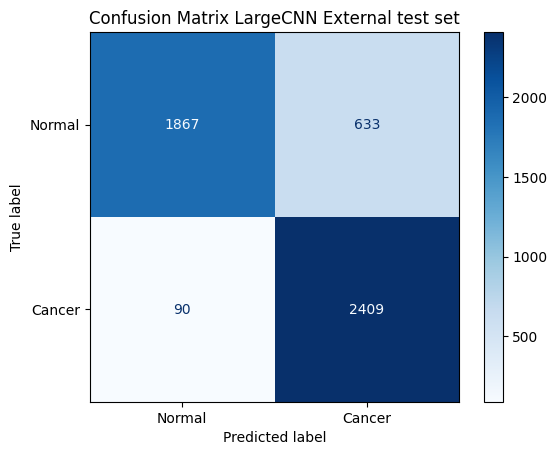


Evaluating ResNet...
Final Validation Performance:
  AUC:         0.9197
  Accuracy:    0.8422
  Sensitivity: 0.9652
  Specificity: 0.7192


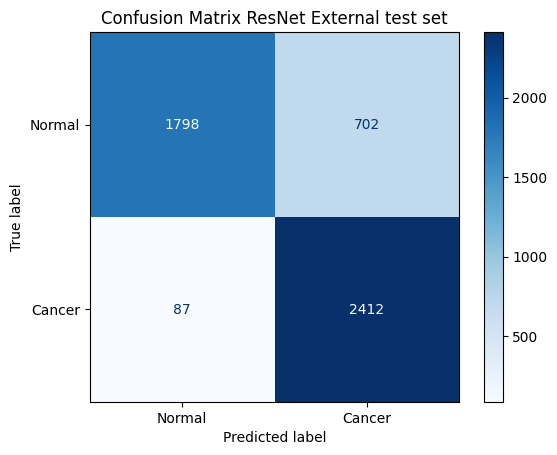

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


for modelname, model in modeldict.items():
    weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
    model_state_dict = torch.load(weights_path)
    model.load_state_dict(model_state_dict)
    print(f"\nEvaluating {modelname}...")
    model.to(device)
    _, va_acc, va_sens, va_spec, va_auc,cm = run_epoch(external_test_loader, model, criterion, train=False, device=device)
    print(f"Final Validation Performance:")
    print(f"  AUC:         {va_auc:.4f}")
    print(f"  Accuracy:    {va_acc:.4f}")
    print(f"  Sensitivity: {va_sens:.4f}")
    print(f"  Specificity: {va_spec:.4f}")
    class_names = ["Normal", "Cancer"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix {modelname} External test set")
    plt.show()

In [20]:
# evaluating and saliency
!pip install torch torchvision captum pillow matplotlib
# !pip install captum

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model_attr_scores = []
model_attr_channels = []
model_preds = []
model_targets = []

for modelname, model in modeldict.items():
  weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
  model_state_dict = torch.load(weights_path)
  model.load_state_dict(model_state_dict)
  print(f"\nEvaluating saliency for {modelname}...")
  model.to(device)
  print(f"Saliency for {modelname}")
  model.eval()
  saliency = Saliency(model)

  attr_scores_list = []
  attr_channels_list = []
  pred_list = []
  target_list = []

  for images, targets in test_loader:
    images = images.to(device, non_blocking=True)
    targets = targets.to(device, non_blocking=True)
    images.requires_grad_()

    with torch.set_grad_enabled(True):
      logits = model(images)
      # loss = criterion(logits, targets)
      pred_classes = logits.argmax(dim=1)
      attr = saliency.attribute(images, target=pred_classes)
      # attr = attr.abs().cpu().detach().numpy()
      attr = attr.abs()
      attr_scores = attr.max(dim=1)[0]    # (batch_size, H, W)
      attr_channel = attr.argmax(dim=1)   # (batch_size, H, W)
    pred_list.append(pred_classes.cpu())
    target_list.append(targets.cpu())
    attr_scores_list.append(attr_scores)
    attr_channels_list.append(attr_channel)

  all_attr_scores = torch.cat(attr_scores_list, dim=0)
  all_attr_channels = torch.cat(attr_channels_list, dim=0)
  model_attr_scores.append(all_attr_scores)
  model_attr_channels.append(all_attr_channels)
  model_preds.append(torch.cat(pred_list, dim=0))
  model_targets.append(torch.cat(target_list, dim=0))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 131.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is i


Evaluating saliency for SmallMLP...
Saliency for SmallMLP

Evaluating saliency for SmallCNN...
Saliency for SmallCNN

Evaluating saliency for LargeCNN...
Saliency for LargeCNN

Evaluating saliency for ResNet...
Saliency for ResNet


In [21]:
import torch.nn.functional as F

center_size = 32
pool_center_mask = torch.zeros((3, 3)).bool()
pool_center_mask[1, 1] = True

center_mask = torch.zeros((96, 96)).bool()
center_mask[32:64, 32:64] = True

all_sal_results = []

# assess the saliency score maps for each model
for i, (saliencies, imp_channels) in enumerate(zip(model_attr_scores, model_attr_channels)):
  # correct shape for avgpool
  sal = saliencies.unsqueeze(1)
  avgpool_sal = F.avg_pool2d(sal, kernel_size = center_size, stride = center_size).squeeze(1)
  center_avg = avgpool_sal[:, pool_center_mask].view(-1) # center
  outer_avg = avgpool_sal[:, ~pool_center_mask].view(len(avgpool_sal), 8).mean(dim=1) # outer
  center_focused = center_avg > outer_avg # vector for each image
  ratio = center_avg/outer_avg
  print(f"length of centeravg is {center_avg.shape}")
  print(f"length of outeravg is {outer_avg.shape}")
  print(f"length of centerfocused is {center_focused.shape}")
  print(f"length of ratio is {ratio.shape}")

  # now get most frequent channel in center and in outer
  imp_channels_center = imp_channels[:, center_mask]
  imp_channels_outer = imp_channels[:, ~center_mask]
  imp_channel_center = torch.mode(imp_channels_center.reshape(len(imp_channels), -1), dim=1).values
  imp_channel_outer = torch.mode(imp_channels_outer.reshape(len(imp_channels), -1), dim=1).values

  for j in range(len(center_avg)):
    row = {
        "modelname": list(modeldict.keys())[i],
        "image index": j,
        "center": center_avg[j].item(),
        "outer": outer_avg[j].item(),
        "center focused": center_focused[j].item(),
        "center ratio": ratio[j].item(),
        "important channel center": imp_channel_center[j].item(),
        "important channel outer": imp_channel_outer[j].item(),
    }
    all_sal_results.append(row)
    # sal_results = {
    #     "model name": [list(modeldict.keys())[i]]*len(center_avg.cpu()), # repeat model name for each image
    #     "image index":
    #     "center": center_avg.cpu(),
    #     "outer": outer_avg.cpu(),
    #     "center focused": center_focused.cpu()
    # }
    # all_sal_results.append(sal_results)

length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])
length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])
length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])
length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])


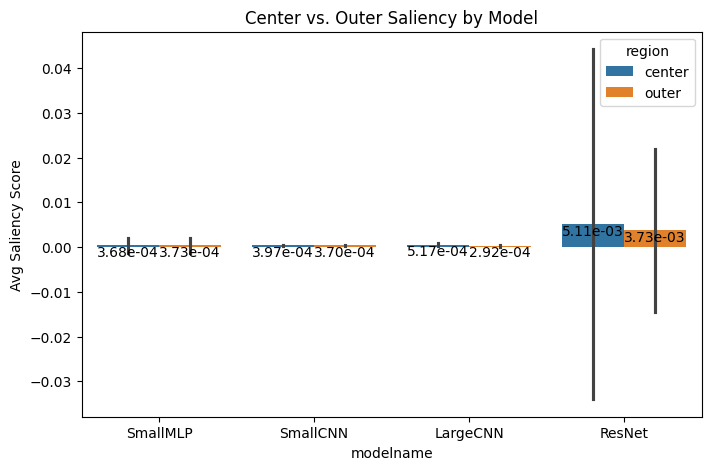

Paired t-test:
SmallMLP: t=-5.226, p=1.8060e-07, meandiff=-4.4744e-06
SmallCNN: t=29.446, p=6.8987e-176, meandiff=2.6931e-05
LargeCNN: t=73.476, p=0.0000e+00, meandiff=2.2479e-04
ResNet: t=4.504, p=6.8233e-06, meandiff=1.3816e-03


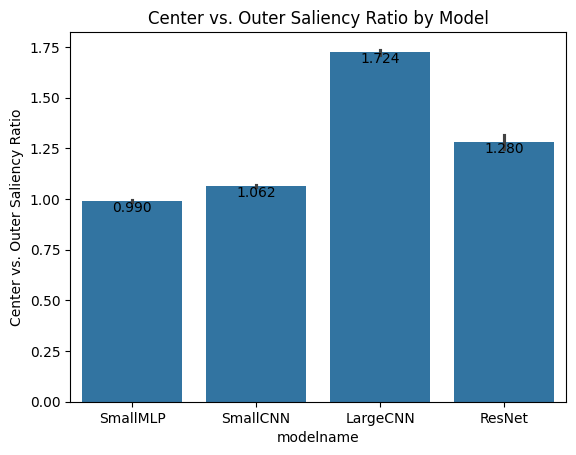

ANOVA: F = 628.3674, p = 0.0000e+00
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
LargeCNN   ResNet  -0.4434   0.0  -0.484 -0.4029   True
LargeCNN SmallCNN  -0.6613   0.0 -0.7018 -0.6207   True
LargeCNN SmallMLP  -0.7341   0.0 -0.8542 -0.6141   True
  ResNet SmallCNN  -0.2178   0.0 -0.2584 -0.1773   True
  ResNet SmallMLP  -0.2907   0.0 -0.4107 -0.1707   True
SmallCNN SmallMLP  -0.0729 0.402 -0.1929  0.0472  False
-------------------------------------------------------
NaN counts per group:
modelname
LargeCNN       0
ResNet         0
SmallCNN       0
SmallMLP    4697
Name: center ratio, dtype: int64



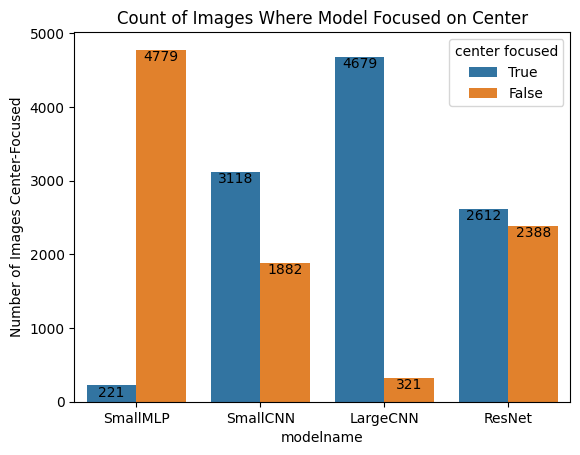

[0 2 1 3]
confusing SmallMLP
221 center-focused images
2468 true positives
232 true negatives
2270 false positives
30 false negatives
confusing SmallCNN
3118 center-focused images
1589 true positives
2134 true negatives
368 false positives
909 false negatives
confusing LargeCNN
4679 center-focused images
1644 true positives
2171 true negatives
331 false positives
854 false negatives
confusing ResNet
2612 center-focused images
1713 true positives
2223 true negatives
279 false positives
785 false negatives


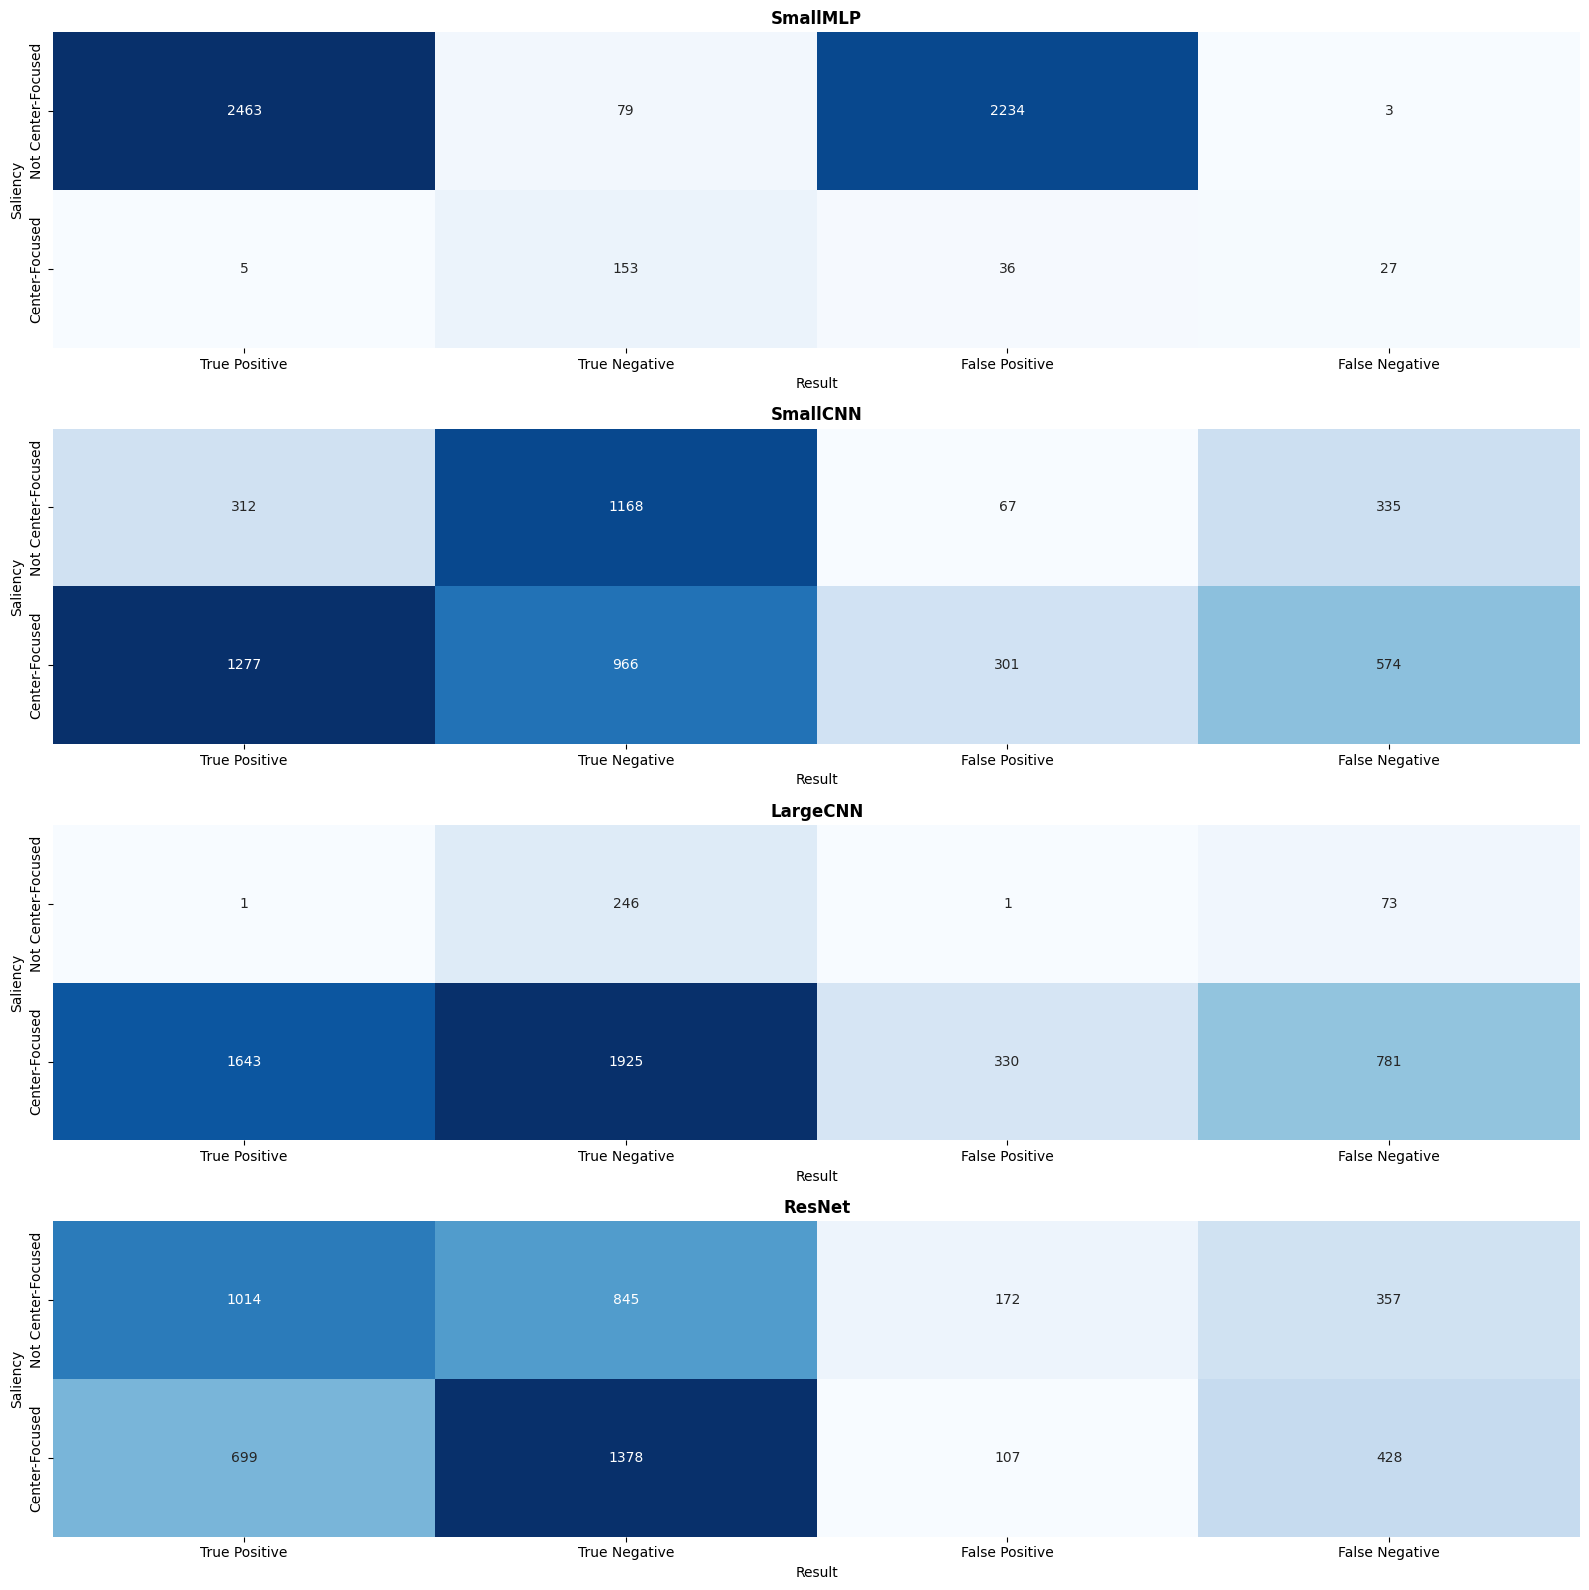

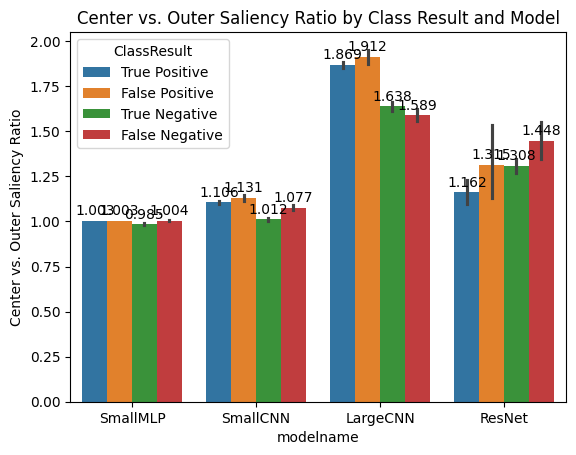

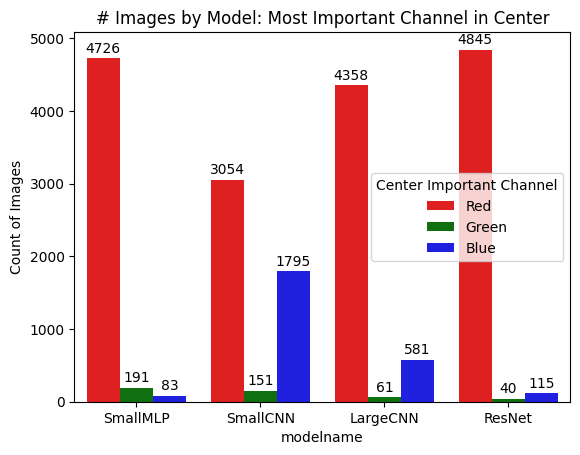

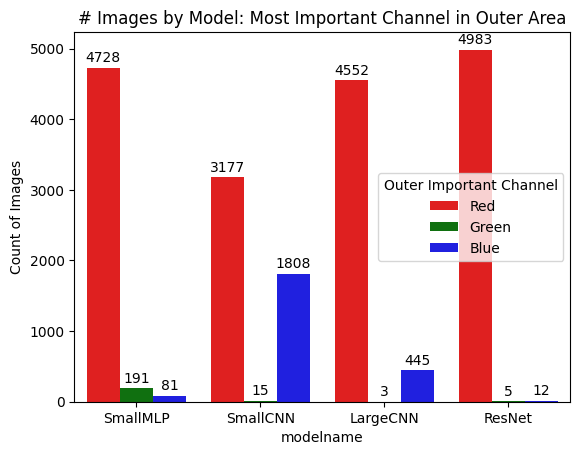

In [22]:
# bar plot- four groups two bars each- for each model, avg. center score vs. avg outer score
sal_df = pd.DataFrame(all_sal_results)
# melt the center and outer columns together
sal_melt_df = sal_df.melt(id_vars=["modelname", "image index", "center focused"], value_vars=["center", "outer"], value_name="saliency", var_name="region")
plt.figure(figsize=(8, 5))
p = sns.barplot(data=sal_melt_df, x="modelname", y="saliency", hue="region", errorbar="sd")
p.set(ylabel="Avg Saliency Score", title="Center vs. Outer Saliency by Model")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, fmt='%.2e', padding=-10)
plt.show()
# paired t-test of center vs. outer for each model
model_names = sal_df["modelname"].unique()
print("Paired t-test:")
for model_name in model_names:
    sub = sal_df[sal_df["modelname"] == model_name]
    tval, pval = ttest_rel(sub["center"], sub["outer"])
    meandiff = (sub["center"] - sub["outer"]).mean()
    print(f"{model_name}: t={tval:.3f}, p={pval:.4e}, meandiff={meandiff:.4e}")

# plot center vs. outer focus ratio for each model
p = sns.barplot(data=sal_df, x="modelname", y="center ratio")
p.set(ylabel="Center vs. Outer Saliency Ratio", title="Center vs. Outer Saliency Ratio by Model")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, fmt='%.3f', padding=-10)
plt.show()
#1-way ANOVA and Tukey post-hoc for significant difference in center focus b/w models
# drop nans because it will break ANOVA- we exclude them from statistical significance here
clean_df = sal_df.dropna(subset=["center ratio"])
groups = [clean_df[clean_df["modelname"] == model_name]["center ratio"]
          for model_name in model_names]
Fval, pval = f_oneway(*groups)
print(f"ANOVA: F = {Fval:.4f}, p = {pval:.4e}")
tukey = pairwise_tukeyhsd(endog=clean_df["center ratio"], groups=clean_df["modelname"], alpha=0.05)
print(tukey)

# print("Dtype:", sal_df["center ratio"].dtype)
# print()

print("NaN counts per group:")
print(sal_df.groupby("modelname")["center ratio"].apply(lambda x: x.isna().sum()))
print()

# print("Counts per group:")
# print(sal_df["modelname"].value_counts())
# print()

# print("Variance per group:")
# print(sal_df.groupby("modelname")["center ratio"].var())

# count how many images were center-focused vs. not
hue_order = [True, False]
p = sns.countplot(data=sal_df, x="modelname", hue="center focused", hue_order=hue_order)
p.set(ylabel="Number of Images Center-Focused", title="Count of Images Where Model Focused on Center")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, padding=-10)
plt.show()

# confusion matrix- 2x4- center-focused or not on one axis, TP, TN, FP, FN on the other
sal_df["Pred Class"] = torch.cat(model_preds, dim=0).cpu().numpy()
sal_df["Target Class"] = torch.cat(model_targets, dim=0).cpu().numpy()

sal_df["Class Result"] = -1

sal_df.loc[(sal_df["Pred Class"] == 1) & (sal_df["Target Class"] == 1), "Class Result"] = 0 # TP
sal_df.loc[(sal_df["Pred Class"] == 0) & (sal_df["Target Class"] == 0), "Class Result"] = 1 # TN
sal_df.loc[(sal_df["Pred Class"] == 1) & (sal_df["Target Class"] == 0), "Class Result"] = 2 # FP
sal_df.loc[(sal_df["Pred Class"] == 0) & (sal_df["Target Class"] == 1), "Class Result"] = 3 # FN

# check to make sure there's only 0, 1, 2, 3 and no -1 in "Class Result"
print(sal_df["Class Result"].unique())

# convert center focused to bool
sal_df["Center-Focused?"] = sal_df["center focused"].astype(int)

fig, axes = plt.subplots(4, 1, figsize=(16, 16))

# plot confusion matrices
for ax, modelname in zip(axes, modeldict.keys()):
  print("confusing", modelname)
  model_df = sal_df[sal_df["modelname"] == modelname]
  # sanity check
  print(f"{model_df['Center-Focused?'].sum()} center-focused images")
  print(f"{(model_df['Class Result'] == 0).sum()} true positives")
  print(f"{(model_df["Class Result"] == 1).sum()} true negatives")
  print(f"{(model_df['Class Result'] == 2).sum()} false positives")
  print(f"{(model_df['Class Result'] == 3).sum()} false negatives")
  cm = confusion_matrix(model_df["Center-Focused?"], model_df["Class Result"])
  # plot heatmap
  s = sns.heatmap(
    cm[:2], annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
    xticklabels=["True Positive", "True Negative", "False Positive", "False Negative"],
    yticklabels=["Not Center-Focused", "Center-Focused"]
  )
  ax.set_title(f"{modelname}", fontsize=12, fontweight="bold")
  ax.set_xlabel("Result", fontsize=10)
  ax.set_ylabel("Saliency", fontsize=10)
plt.tight_layout() # adjust spacing
plt.show()

# plot saliency ratio by class result and model
# make a new column where the class result labels are strings
sal_df["ClassResult"] = sal_df["Class Result"].map({
    0: "True Positive",
    1: "True Negative",
    2: "False Positive",
    3: "False Negative"
})
hue_order = ["True Positive", "False Positive", "True Negative", "False Negative"]
# bar plot- ratio in TP, TN, FP, FN for each mode
p = sns.barplot(data=sal_df, x="modelname", y="center ratio", hue="ClassResult", hue_order=hue_order)
p.set(ylabel="Center vs. Outer Saliency Ratio", title="Center vs. Outer Saliency Ratio by Class Result and Model")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, fmt='%.3f', padding=2)
plt.show()

# make new columns where the channel index is the color name
sal_df["Center Important Channel"] = sal_df["important channel center"].map({
    0: "Red",
    1: "Green",
    2: "Blue",
})
sal_df["Outer Important Channel"] = sal_df["important channel outer"].map({
    0: "Red",
    1: "Green",
    2: "Blue",
})
hue_order = ["Red", "Green", "Blue"]
palette = ["red", "green", "blue"]
# plot important channel center by model
p = sns.countplot(data=sal_df, x="modelname", hue="Center Important Channel", hue_order=hue_order, palette=palette)
p.set(ylabel="Count of Images", title="# Images by Model: Most Important Channel in Center")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, padding=2)
plt.show()

# plot important channel outer by model
p = sns.countplot(data=sal_df, x="modelname", hue="Outer Important Channel", hue_order=hue_order, palette=palette)
p.set(ylabel="Count of Images", title="# Images by Model: Most Important Channel in Outer Area")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, padding=2)
plt.show()


1 tensor(1)
(96, 96)


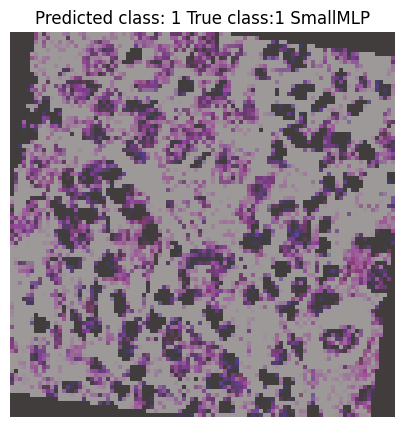

0 tensor(1)
(96, 96)


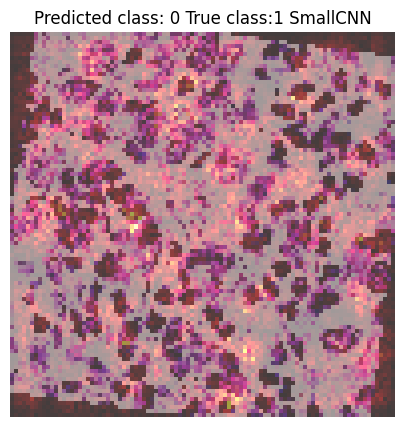

0 tensor(1)
(96, 96)


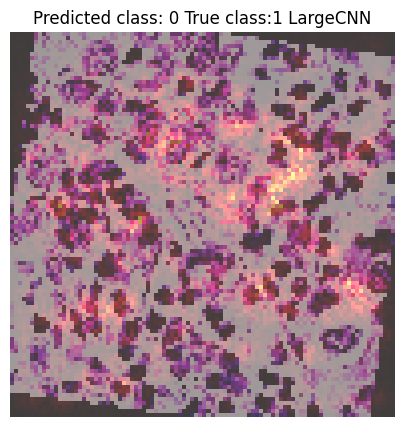

0 tensor(1)
(96, 96)


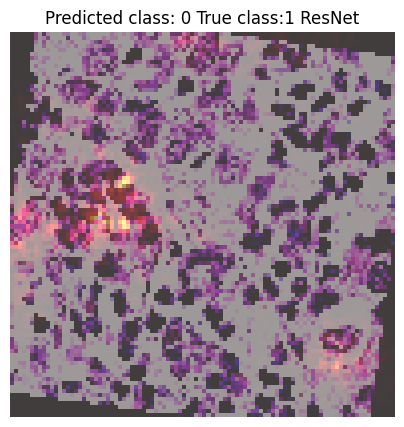

In [23]:
# representative images

# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# load internal test set images and run evaluation
images,targets = next(iter(test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() != 0 and pred_class !=0:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()


1 tensor(0)
(96, 96)


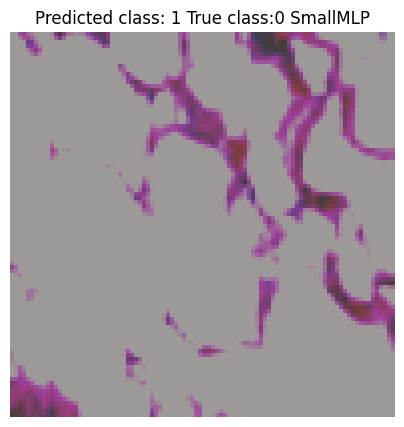

0 tensor(0)
(96, 96)


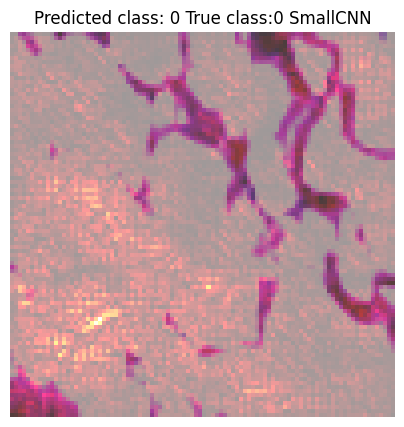

0 tensor(0)
(96, 96)


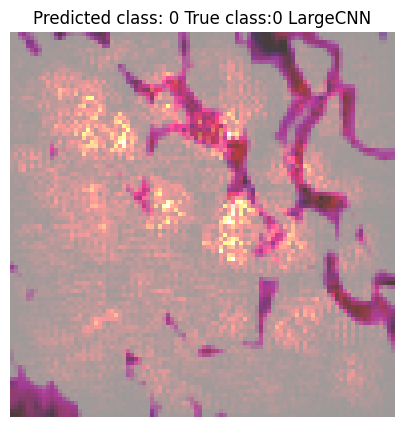

0 tensor(0)
(96, 96)


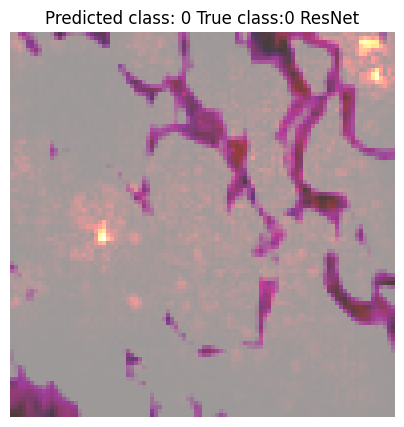

In [24]:
# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


images,targets = next(iter(external_test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() != 0 and pred_class !=0:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()


1 tensor(1)
(96, 96)


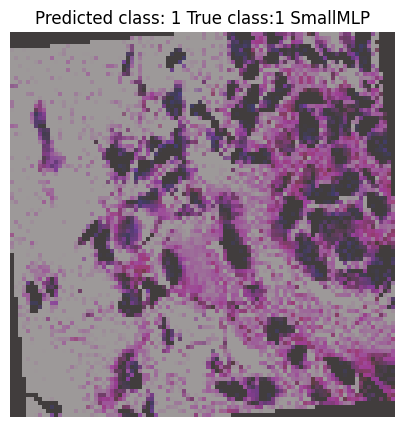

1 tensor(1)
(96, 96)


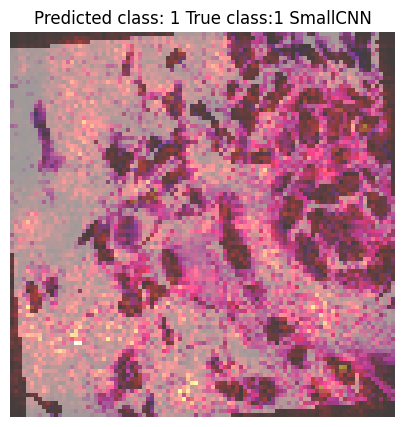

1 tensor(1)
(96, 96)


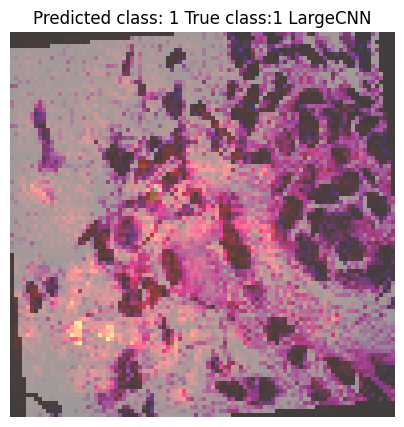

1 tensor(1)
(96, 96)


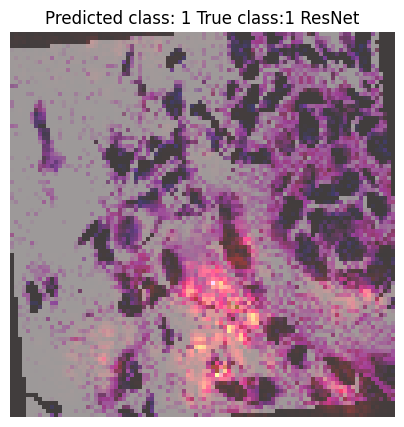

In [25]:
# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


images,targets = next(iter(test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() != 1 and pred_class !=1:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()


1 tensor(1)
(96, 96)


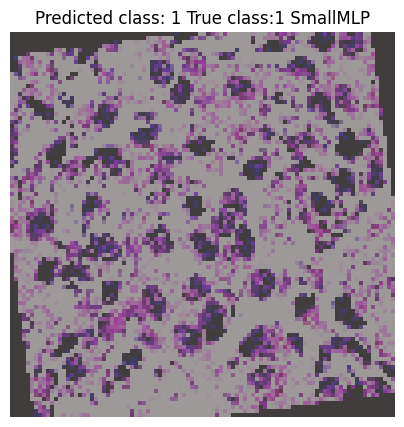

0 tensor(1)
(96, 96)


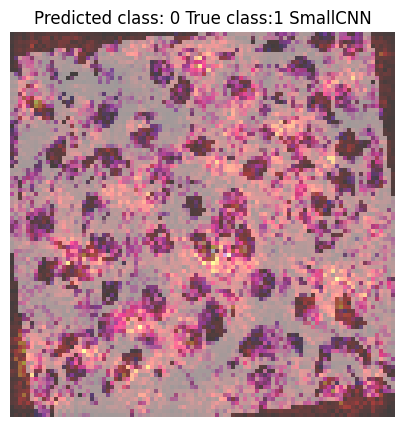

0 tensor(1)


(96, 96)


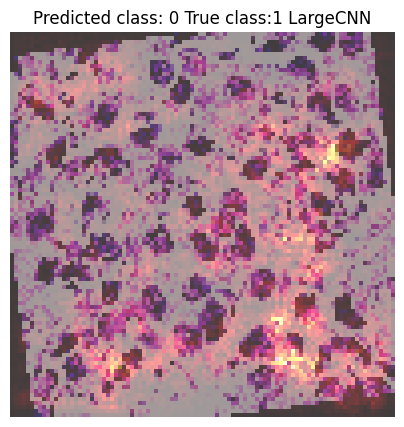

0 tensor(1)


(96, 96)


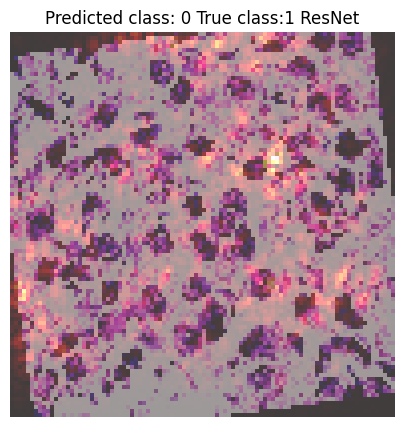

In [26]:
# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


images,targets = next(iter(test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() == pred_class:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor = images[idx].to(device).unsqueeze(0)
input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()
